Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.


The following are key factors to obtaining good segregation topics:

1. The quality of text processing.
2. The variety of topics the text talks about.
3. The choice of topic modeling algorithm.
4. The number of topics fed to the algorithm.
5. The algorithms tuning parameters.

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

Importing Packages

In [1]:
import nltk
nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinminaw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Reading Data 

In [12]:
# something wrong with path to import
reviews = pd.read_csv('reviews_nontest.csv')
reviews.head()

,review_title,review_body,review_date,account_name,account_id,account_level,account_photo,review_photo,restaurant_code,location
0,Best Kerala Biriyani And Fish Curry,The malabar fish curry here is yummmm. Must tr...,4/3/20,Nashiya Salim,@nashiyasalim,Level 2 Burppler,https://graph.facebook.com/10220268216879090/p...,https://burpple-2.imgix.net/foods/30e2d95540c7...,paradise-biryani,Yishun
1,Wantan Mee,I like it that the handmade egg noodles were s...,6/10/20,Li Ting Tan,@Fatspoting,Level 6 Burppler,https://s3.burpple.com/assets/images/DisplayIc...,https://burpple-3.imgix.net/foods/3246d3378f6c...,engs-wantan-noodle,Katong
2,Eng's Noodle House,Delectable noodles n its really gd ! Nothing b...,11/9/20,Ravishing Rick Rude,@Rampage5,Level 5 Burppler,https://burpple.imgix.net/users/4aaea47eba8fd3...,https://burpple.imgix.net/foods/2f86b0a1829634...,engs-wantan-noodle,Katong
3,Wanton Noodles,For wanton Noodles + zichar options. Can't com...,3/1/20,Vanessa S,@vanessasng,Level 10 Burppler,https://burpple-2.imgix.net/users/e8de139e0b30...,https://burpple.imgix.net/foods/cb581a01aa78e7...,engs-wantan-noodle,Katong
4,Eng Wonton Noodle In Novena!,There is a new ENG WONTON NOODLE at novena! Ne...,21/9/19,Spoons Of Delights,@spoonsofdelights,Level 9 Burppler,https://burpple-1.imgix.net/users/63e3b3ccd8de...,https://burpple-1.imgix.net/foods/1d5df54d308f...,engs-wantan-noodle,Katong


In [72]:
reviews.review_body.values[5000]

'Steak was stingy and small, meat was dry and tough. Service was bad. Will not be coming back again.'

Data Preprocessing

Tokenize + Lowercase + remove punctuations + remove stopwords + include bi-grams on top of unigrams + lemmatization

Try: Decontractions + OOV words https://towardsdatascience.com/yelp-review-analysis-for-chipotle-with-natural-language-processing-bf4b3e5db140

In [22]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Tokenize + lowercase + remove punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations/Remove accentuation from the given string

# Convert to list
data = reviews.review_body.values.tolist()
data_words = list(sent_to_words(data))

In [23]:
# remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts] 

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv - default 
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

##### Topic Modelling

Types of Topic Models - https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05 

In [29]:
# Create Dictionary & Corpus required for topic modelling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [30]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ask', 1),
  ('chicken', 2),
  ('cone', 1),
  ('crave', 1),
  ('curry', 3),
  ('dum', 1),
  ('even', 1),
  ('fish', 3),
  ('get', 1),
  ('good', 1),
  ('kerala', 1),
  ('life', 1),
  ('like', 1),
  ('malabar', 2),
  ('nice', 1),
  ('occasionally', 1),
  ('one', 1),
  ('rice', 1),
  ('small', 1),
  ('starter', 1),
  ('try', 1),
  ('yummmm', 1)]]

###### Baseline LDA Model (No hyperparamter tuning etc)

In [34]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.139*"foodstagram" + 0.112*"portion" + 0.079*"dayseat" + '
  '0.079*"hungrygowhere" + 0.049*"sgcafe" + 0.040*"warm" + 0.040*"openricesg" '
  '+ 0.040*"next" + 0.031*"igfood" + 0.024*"second"'),
 (1,
  '0.418*"singapore" + 0.089*"friend" + 0.078*"road" + 0.057*"hand" + '
  '0.056*"night" + 0.052*"address" + 0.045*"monday" + 0.030*"dumpling" + '
  '0.028*"late" + 0.017*"literally"'),
 (2,
  '0.417*"day" + 0.254*"breakfast" + 0.073*"beautiful" + 0.045*"person" + '
  '0.039*"believe" + 0.012*"ahead" + 0.000*"coffee" + 0.000*"cream" + '
  '0.000*"dessert" + 0.000*"cake"'),
 (3,
  '0.314*"great" + 0.211*"hot" + 0.114*"fan" + 0.091*"though" + 0.050*"run" + '
  '0.026*"pass" + 0.025*"delight" + 0.025*"tiny" + 0.021*"tastebud" + '
  '0.000*"cream"'),
 (4,
  '0.699*"egg" + 0.064*"lover" + 0.029*"hide" + 0.029*"tslmakan" + '
  '0.019*"hahaha" + 0.018*"weather" + 0.014*"mine" + 0.009*"squeeze" + '
  '0.000*"salt" + 0.000*"truffle"'),
 (5,
  '0.289*"chicken" + 0.270*"rice" + 0.122*"spicy" 

Evaluating Topic models :
1. Perplexity - usually not correlated with
2. Topic Coherence  - http://qpleple.com/topic-coherence-to-evaluate-topic-models/
Coherence looks at the most-frequently occurring words in each of the generated topics, rates the semantic similarity between them (using either UCI or Umass to do the pairwise calculations) and then finds the mean coherence score across all the topics in the model.


In [36]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.460264091703785

Coherence Score:  0.5592305467800803


In [63]:
# Visualize the topics
%matplotlib inline
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.277610  0.289464       1        1  37.427370
6     -0.228888 -0.010851       2        1  16.593293
13    -0.173376 -0.165663       3        1   8.344130
10    -0.171004 -0.282976       4        1   6.549063
17    -0.126754  0.195162       5        1   4.176129
5     -0.057855 -0.045098       6        1   3.417627
0     -0.048155 -0.059034       7        1   3.312208
14    -0.005546 -0.028093       8        1   2.786039
11     0.017995 -0.015135       9        1   2.364758
16     0.017484 -0.015380      10        1   2.220012
9      0.036597 -0.006499      11        1   2.116097
1      0.036923 -0.006348      12        1   2.108408
12     0.048148 -0.001731      13        1   1.837440
3      0.107083  0.016733      14        1   1.315678
18     0.118202  0.019301      15        1   1.198659
4      0.102187  0.015518      16        1   1.193885
2      0.137487  0.023135      17        1   0.872549
19     0.146535  0.024678      18        1   0.843251
15     0.144211  0.024296      19        1   0.803064
7      0.176337  0.028523      20        1   0.520340, topic_info=            Term           Freq          Total Category  logprob  loglift
316         food  105136.000000  105136.000000  Default  30.0000  30.0000
27           egg   61984.000000   61984.000000  Default  29.0000  29.0000
71       burpple   95610.000000   95610.000000  Default  28.0000  28.0000
185    singapore   65489.000000   65489.000000  Default  27.0000  27.0000
1        chicken   73466.000000   73466.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
1128  restaurant       0.088532       2.005904  Topic20 -12.9865   2.1380
1089    mushroom       0.088531       2.005817  Topic20 -12.9865   2.1380
1943       roast       0.088529       2.005346  Topic20 -12.9865   2.1382
1122     truffle       0.088530       2.006293  Topic20 -12.9865   2.1377
2684      coffee       0.088530       2.006004  Topic20 -12.9865   2.1379

[882 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
135       1  0.999933         add
561      12  0.999768     address
136       9  0.999825  affordable
395      17  0.997709       ahead
287      15  0.998083        alot
...     ...       ...         ...
457       3  0.999699        wish
181       2  0.999943       worth
692       5  0.999735         yum
480      13  0.999924       yummy
66        5  0.998526      zichar

[354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 14, 11, 18, 6, 1, 15, 12, 17, 10, 2, 13, 4, 19, 5, 3, 20, 16, 8])

###### LDA Mallet Model - Higher Coherence Score

The difference between Mallet and Gensim’s standard LDA is that Gensim uses a Variational Bayes sampling method which is faster but less precise that Mallet’s Gibbs Sampling. Mallet Model uses an optimized Gibbs sampling algorithm for Latent Dirichlet Allocation. **Mallet’s version often gives a better quality of topics.**

In [61]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/xinminaw/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=id2word)

In [62]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=-1, formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('dish', 0.04460098349805767),
   ('menu', 0.025717230607741094),
   ('pasta', 0.023375468194397897),
   ('restaurant', 0.022155053759361252),
   ('serve', 0.021558547222029007),
   ('crab', 0.021244485476225105),
   ('great', 0.01809754462733096),
   ('chef', 0.014484780652110221),
   ('seafood', 0.012798543090746982),
   ('place', 0.011780477163073927)]),
 (1,
  [('meat', 0.04871823956442831),
   ('pork', 0.04790459653776351),
   ('beef', 0.04509501954488343),
   ('tender', 0.03383489808739355),
   ('sauce', 0.03195457559681698),
   ('grill', 0.01990916864442273),
   ('juicy', 0.018537100376937038),
   ('raman', 0.017557674856903533),
   ('side', 0.014366361859556052),
   ('serve', 0.013949724277537344)]),
 (2,
  [('time', 0.04856005118382785),
   ('order', 0.04463044105685724),
   ('place', 0.03266601946842285),
   ('back', 0.018463314556511103),
   ('good', 0.017997089626192557),
   ('long', 0.017916358036527007),
   ('wait', 0.01441664362452545),
   ('service', 0.014400497

###### Determining Optimal No of Topics

In [56]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [57]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

  0%|          | 0/540 [3:27:12<?, ?it/s]


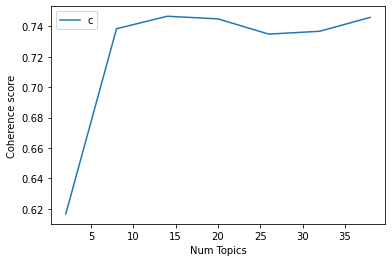

In [58]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# 14 topics

In [59]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6166
Num Topics = 8  has Coherence Value of 0.7384
Num Topics = 14  has Coherence Value of 0.7466
Num Topics = 20  has Coherence Value of 0.7449
Num Topics = 26  has Coherence Value of 0.7349
Num Topics = 32  has Coherence Value of 0.7367
Num Topics = 38  has Coherence Value of 0.7458


In [ ]:
# Select the model and print the topics
# pick the model that gave the highest CV before flattening out
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

###### Hyperparameter tuning to improve coherence score + determine optimal no. of topics

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=But%20before%20that%E2%80%A6-,What%20is%20topic%20coherence%3F,are%20artifacts%20of%20statistical%20inference.

Now that we have the baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:
Number of Topics (K)
Dirichlet hyperparameter alpha: Document-Topic Density
Dirichlet hyperparameter beta: Word-Topic Density

Reference for subsequent : https://towardsdatascience.com/yelp-review-analysis-for-chipotle-with-natural-language-processing-bf4b3e5db140

In [60]:
# List of food

In [ ]:
>>> from nltk.corpus import wordnet as wn
>>> food = wn.synset('food.n.02')
>>> list(set([w for s in food.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))

In [ ]:
# determine optimal topics
# try out removing food names
# determine topics